<a href="https://colab.research.google.com/github/ANUPRIYAR/Multilabel_Classification_NLP_LSTM/blob/main/MultiClassClassification_Consumer_complaints_BidirectionalLSTM_Resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Source: https://catalog.data.gov/dataset/consumer-complaint-database

We will only be using 'Consumer complaint narrative' and 'Product' field for Multi Label Classification model. Other feilds are just used for EDA.

In [4]:
from google.colab import drive

In [5]:
# !unzip /content/drive/MyDrive/Deep_learning/complaints.csv.zip

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

warnings.filterwarnings('ignore')

In [7]:
data = pd.read_csv('/content/drive/MyDrive/Deep_learning/complaints.csv.zip')
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
3,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX,NaN,Consent provided,Web,2019-09-15,Closed with explanation,Yes,NaN,3374555
4,2020-11-30,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MA,01605,NaN,NaN,Phone,2020-11-30,Closed with explanation,Yes,NaN,3981945


In [8]:
data.shape

(1869768, 18)

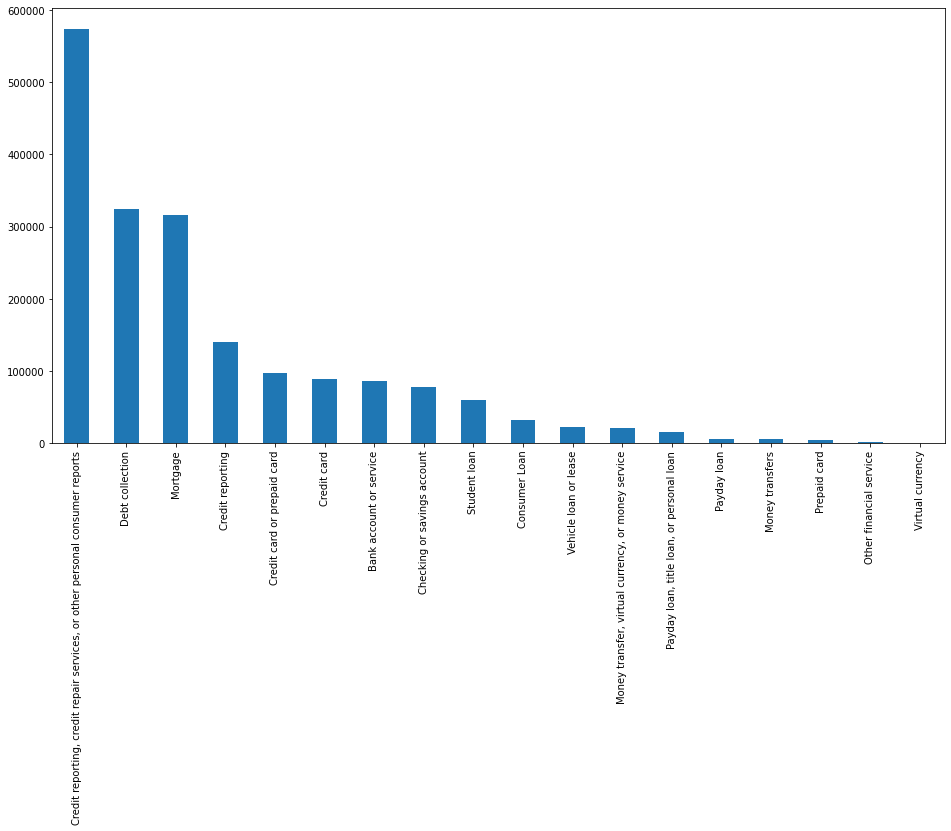

In [9]:
plt.figure(figsize=(16,8))
data['Product'].value_counts().plot(kind='bar')

In [10]:
data['Product'].nunique()

18

If we consider Product field as categorical variable, then there are 18 categories.

In [11]:
data['Sub-product'].value_counts()

Credit reporting                              566753
Checking account                              118233
Other mortgage                                 86635
General-purpose credit card or charge card     72389
Conventional fixed mortgage                    70613
                                               ...  
Credit repair                                    103
Traveler’s/Cashier’s checks                       88
Transit card                                      37
Electronic Benefit Transfer / EBT card            12
Student prepaid card                              12
Name: Sub-product, Length: 76, dtype: int64

In [12]:
data['Sub-product'].nunique()

76

There are 76 unique values for Sub-product , hence better to not consider as categorical variable

# **Reducing the number of categorical Varibales in Product field**

In [13]:
# Reducing the number of Categorical variables

# Merging categories- 'Credit card' and 'Prepaid Card' into 'Credit Card or prepaid Card'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Prepaid card', 'Product'] = 'Credit card or prepaid card'


In [14]:
data.loc[data['Product'] == 'Credit card', 'Product'].count(), data.loc[data['Product'] == 'Prepaid card', 'Product'].count()

(0, 0)

In [15]:
# Merging 'Virtual currency' and 'Money transfers' into 'Money transfer, virtual currency, or money service'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
data.loc[data['Product'] == 'Money transfers', 'Product'] = 'Money transfer, virtual currency, or money service'

data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'

In [16]:
data.loc[data['Product'] == 'Student loan', 'Product'] = 'Student loan or Consumer loan or Vehicle loan'
data.loc[data['Product'] == 'Consumer Loan', 'Product'] = 'Student loan or Consumer loan or Vehicle loan'
data.loc[data['Product'] == 'Vehicle loan or lease', 'Product'] = 'Student loan or Consumer loan or Vehicle loan'

In [17]:
data.loc[data['Product'] == 'Payday loan, title loan, or personal loan', 'Product'] = 'Student loan or Consumer loan or Vehicle loan or other loans'
data.loc[data['Product'] == 'Student loan or Consumer loan or Vehicle loan', 'Product'] = 'Student loan or Consumer loan or Vehicle loan or other loans'

In [18]:
data['Product'].nunique()

10

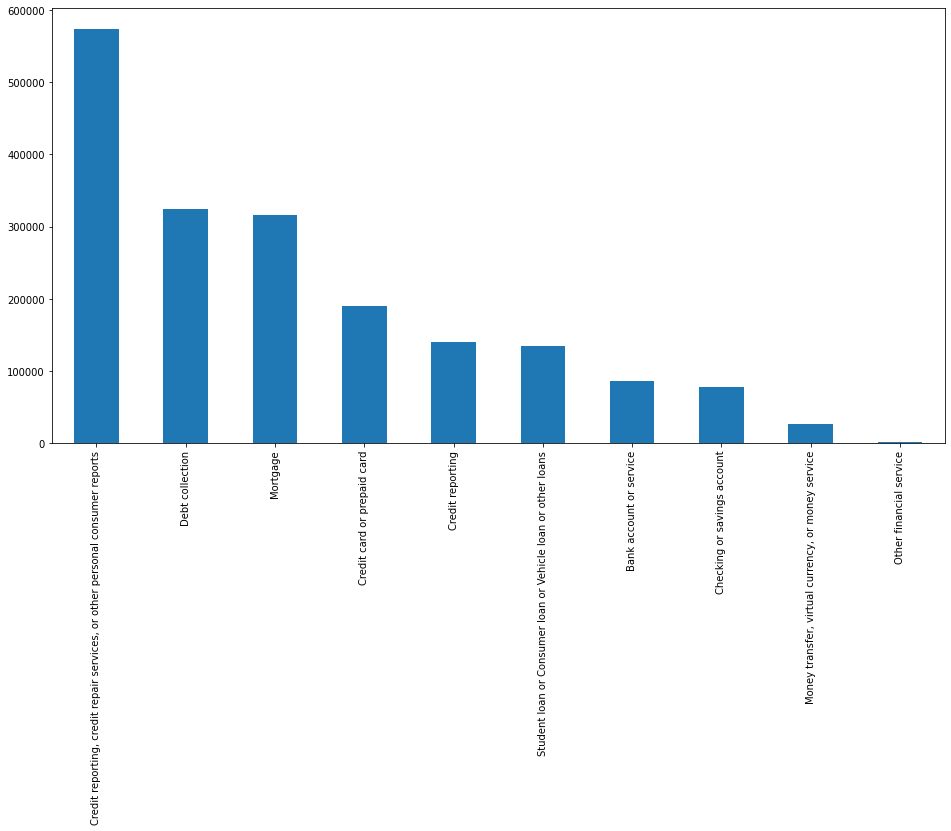

In [19]:
plt.figure(figsize=(16,8))
data['Product'].value_counts().plot(kind='bar')

# **Handling Missing Values**

In [20]:
data['Company public response'].isnull().sum() , data['Consumer disputed?'].isnull().sum() , data['Tags'].isnull().sum() , data['Company public response'].isnull().sum() 

(1096549, 1101294, 1626269, 1096549)

There are a huge set of rows with Null values , hence we can delete the column

In [21]:
data.drop(['Company public response', 'Consumer disputed?', 'Tags', 'Company public response'], axis=1, inplace=True)

In [22]:
data.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company,State,ZIP code,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,TRANSWORLD SYSTEMS INC,FL,335XX,Consent provided,Web,2019-09-24,Closed with explanation,Yes,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Experian Information Solutions Inc.,PA,15206,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,3379500


**Summary of all the columns with missing values**

In [23]:
#  Get the summary number missing fields in each column
data.isnull().sum()

Date received                         0
Product                               0
Sub-product                      235165
Issue                                 0
Sub-issue                        592093
Consumer complaint narrative    1233643
Company                               0
State                             34968
ZIP code                         182847
Consumer consent provided?       666447
Submitted via                         0
Date sent to company                  0
Company response to consumer          2
Timely response?                      0
Complaint ID                          0
dtype: int64

In [24]:
data.drop(['Sub-product', 'Sub-issue' ,'ZIP code', 'Consumer consent provided?', 'State' ], axis=1, inplace=True)

In [25]:
data.isnull().sum()

Date received                         0
Product                               0
Issue                                 0
Consumer complaint narrative    1233643
Company                               0
Submitted via                         0
Date sent to company                  0
Company response to consumer          2
Timely response?                      0
Complaint ID                          0
dtype: int64

We can see 'Consumer complaint narrative' is having around 12 lakhs missing fields, Since we will be parsing the narrative to find the label of the complaint, missing rows would not make any sense.

In [26]:
# Hence we are dropping all the rows with missing fields
data.dropna(inplace=True)

In [27]:
data.shape

(636124, 10)

In [28]:
data.reset_index()

,index,Date received,Product,Issue,Consumer complaint narrative,Company,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID
0,0,2019-09-24,Debt collection,Attempts to collect debt not owed,transworld systems inc. \nis trying to collect...,TRANSWORLD SYSTEMS INC,Web,2019-09-24,Closed with explanation,Yes,3384392
1,2,2019-11-08,Debt collection,Communication tactics,"Over the past 2 weeks, I have been receiving e...","Diversified Consultants, Inc.",Web,2019-11-08,Closed with explanation,Yes,3433198
2,3,2019-09-15,Debt collection,Attempts to collect debt not owed,Pioneer has committed several federal violatio...,Pioneer Capital Solutions Inc,Web,2019-09-15,Closed with explanation,Yes,3374555
3,6,2019-07-26,"Credit reporting, credit repair services, or o...",Problem with a credit reporting company's inve...,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",Experian Information Solutions Inc.,Web,2019-07-26,Closed with explanation,Yes,3319331
4,7,2019-07-08,"Credit reporting, credit repair services, or o...",Problem with a credit reporting company's inve...,Hello This complaint is against the three cred...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Web,2019-07-08,Closed with explanation,Yes,3299394
...,...,...,...,...,...,...,...,...,...,...,...
636119,1869763,2016-07-11,Student loan or Consumer loan or Vehicle loan ...,Managing the loan or lease,I was on automatic payment for my car loan. In...,NISSAN MOTOR ACCEPTANCE CORPORATION,Web,2016-07-11,Closed with explanation,Yes,2007463
636120,1869764,2017-01-24,Debt collection,Communication tactics,I recieved a collections call from an unknown ...,"CMRE Financial Services, Inc.",Web,2017-01-24,Closed with explanation,Yes,2308954
636121,1869765,2015-03-26,Mortgage,"Loan servicing, payments, escrow account","On XXXX XXXX, 2015, I contacted XXXX XXXX, who...",Finance of America Mortgage LLC,Web,2015-03-26,Closed with monetary relief,Yes,1303324
636122,1869766,2015-12-12,Mortgage,"Loan servicing, payments, escrow account",I can not get from chase who services my mortg...,JPMORGAN CHASE & CO.,Web,2015-12-12,Closed with explanation,Yes,1694674


In [29]:
data['Submitted via'].value_counts()

Web    636124
Name: Submitted via, dtype: int64

In [30]:
data['Company response to consumer'].value_counts()

Closed with explanation            524944
Closed with non-monetary relief     71986
Closed with monetary relief         31860
Closed                               3741
Untimely response                    3575
In progress                            18
Name: Company response to consumer, dtype: int64

In [31]:
data['Timely response?'].value_counts()

Yes    620840
No      15284
Name: Timely response?, dtype: int64

In [32]:
data['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    224651
Debt collection                                                                 128025
Mortgage                                                                         71758
Credit card or prepaid card                                                      66477
Student loan or Consumer loan or Vehicle loan or other loans                     58230
Credit reporting                                                                 31588
Checking or savings account                                                      26888
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               13330
Other financial service                                                            292
Name: Product, dtype: int64

In [33]:
data['Company'].value_counts(sort=True, ascending=False).head(20)

EQUIFAX, INC.                             72855
Experian Information Solutions Inc.       69299
TRANSUNION INTERMEDIATE HOLDINGS, INC.    65909
CITIBANK, N.A.                            20177
JPMORGAN CHASE & CO.                      19126
WELLS FARGO & COMPANY                     19078
BANK OF AMERICA, NATIONAL ASSOCIATION     19012
CAPITAL ONE FINANCIAL CORPORATION         17208
Navient Solutions, LLC.                   15340
SYNCHRONY FINANCIAL                       11098
AMERICAN EXPRESS COMPANY                   7201
U.S. BANCORP                               6513
Ocwen Financial Corporation                6175
PORTFOLIO RECOVERY ASSOCIATES INC          6139
NATIONSTAR MORTGAGE                        5879
AES/PHEAA                                  5819
DISCOVER BANK                              5020
ENCORE CAPITAL GROUP INC.                  5006
Alliance Data Card Services                4968
PNC Bank N.A.                              4913
Name: Company, dtype: int64

Text(0, 0.5, 'Number of occurences')

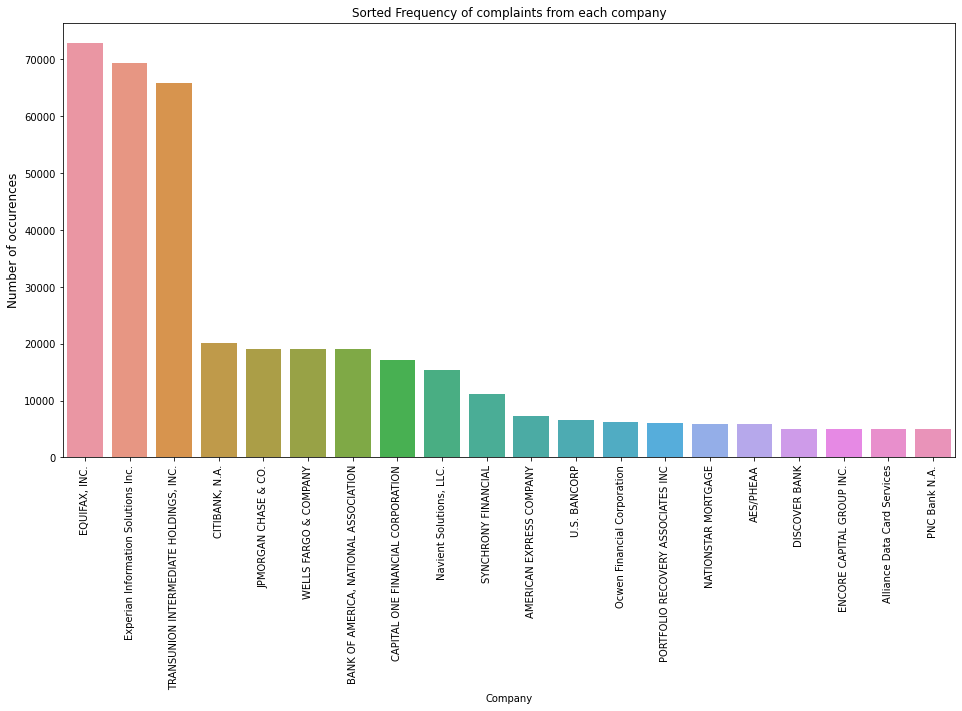

In [34]:
plt.figure(figsize=(16,8))
plt.xticks(rotation='90')
plt.title("Sorted Frequency of complaints from each company")
sns.countplot(data=data, x='Company', order=data['Company'].value_counts(sort=True, ascending=False).head(20).index)
plt.ylabel("Number of occurences", fontsize=12)

**Text processing**

In [35]:
pd.set_option('display.max_colwidth', None)

In [36]:
data['Consumer complaint narrative'][2]

'Over the past 2 weeks, I have been receiving excessive amounts of telephone calls from the company listed in this complaint. The calls occur between XXXX XXXX and XXXX XXXX to my cell and at my job. The company does not have the right to harass me at work and I want this to stop. It is extremely distracting to be told 5 times a day that I have a call from this collection agency while at work.'

In [37]:
import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
 def Clean_Text(text):
   punc = list(string.punctuation)
   punc.remove('.')
   stop_words = stopwords.words('english')
   text = re.sub(r'[\n|\r|\r\n]+', ' ', text)
   text = re.sub(r'[XX]+', '', text)
   text = re.sub(r'[0-9]', '', text)
   text = re.sub(r'//', '', text)
   text = re.sub(r'{$.}', '', text)

   text = [word for word in text.split() if word not in stop_words + punc]
   text = ' '.join(text)
   return text.lower()


In [39]:
# data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(Clean_Text)

In [40]:
data.reset_index(inplace=True)

In [41]:
data.tail(5)

,index,Date received,Product,Issue,Consumer complaint narrative,Company,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID
636119,1869763,2016-07-11,Student loan or Consumer loan or Vehicle loan or other loans,Managing the loan or lease,I was on automatic payment for my car loan. In fine print supposedly I do n't see it the final payment must be made by check. I did not get a notice until it was too late and now I am stuck with a negative mark on my credit report. We were never late for the entire loan. We also moved and the notice was delayed to us and we had our first baby not that they are excuses but if we paid on time all along and only had a small final payment how can that affect our credit.,NISSAN MOTOR ACCEPTANCE CORPORATION,Web,2016-07-11,Closed with explanation,Yes,2007463
636120,1869764,2017-01-24,Debt collection,Communication tactics,"I recieved a collections call from an unknown company this morning while in the hospital. After being on hold for 10 minutes through an automated system where the recording told me to wait for a representative, I was hung up on and directed to the website. Their website ( http : //www.cmrefsi.com/ ) is not trusted and upon research, they seem to be a collection scam. I have no business nor have I authorized or agreed to any payments to this or any company or missed any payments to any outstanding accounts.","CMRE Financial Services, Inc.",Web,2017-01-24,Closed with explanation,Yes,2308954
636121,1869765,2015-03-26,Mortgage,"Loan servicing, payments, escrow account","On XXXX XXXX, 2015, I contacted XXXX XXXX, who is a Branch Manager ( XXXX # XXXX ) with GATEWAY FUNDING, and learned I can lower my mortgage monthly payment from approximately {$2400.00} to {$2000.00}. I was ecstatic because I would have saved over {$400.00} each month. XXXX XXXX sent me via email the DETAILS OF TRANSACTION detailing I would pay that amount. During the escrow process on XXXX XXXX, I was instructed to wire {$690.00} and thought my application was completed. On XXXX XXXX, XXXX XXXX contacted me and stated it required me to pay an additional {$290.00} because certain expenses were overlooked by XXXX XXXX. I contacted XXXX XXXX about my additional expense to which he stated, GATEWAY FUNDING will refund {$290.00} back to me after I send in the money to complete the escrow process. \n\nI am complaining about XXXX issues : I learned my mortgage monthly payment was not {$2000.00} as promised by XXXX XXXX, but instead {$2200.00}, and I have not received my refund in the amount of {$290.00}, as promised by XXXX XXXX on XXXX XXXX. When I contacted him via telephone on XXXX XXXX about the monthly payment, he stated he made a mistake. I have contacted XXXX XXXX on XXXX occasions about the refund check. I contacted him via telephone on XXXX XXXX, which he stated he will issue the check on XXXX XXXX, the Friday after the application process was completed. I contacted him on XXXX XXXX, and he stated he would authorize the refund check. When I last contacted him on XXXX XXXX, I was told I should have already received it, then later verified by XXXX XXXX that he check has not been issued or delivered. \n\nIt is my belief XXXX XXXX is taking advantage of my lack of knowledge in the loan application process by informing me of his many years of outstanding services and a promise of lower month mortgage payment only to deceit me to benefit himself.",Finance of America Mortgage LLC,Web,2015-03-26,Closed with monetary relief,Yes,1303324
636122,1869766,2015-12-12,Mortgage,"Loan servicing, payments, escrow account","I can not get from chase who services my mortgage, who owns it and who has original loan docs and signatures.",JPMORGAN CHASE & CO.,Web,2015-12-12,Closed with explanation,Yes,1694674
636123,1869767,2016-08-09,Credit card or prepaid card,Transaction issue,"I made a payment to CITI XXXX Credit Card on XXXX XXXX, 2016 using a CITI prepaid Debit Card issued to us from a furnace/ai

Initializing x and y variables 

In [43]:
x = data['Consumer complaint narrative']
Y = data['Product']
Y.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    224651
Debt collection                                                                 128025
Mortgage                                                                         71758
Credit card or prepaid card                                                      66477
Student loan or Consumer loan or Vehicle loan or other loans                     58230
Credit reporting                                                                 31588
Checking or savings account                                                      26888
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               13330
Other financial service                                                            292
Name: Product, dtype: int64

In [44]:
y = pd.get_dummies(Y,drop_first=True)
y.head(5)

,Checking or savings account,Credit card or prepaid card,Credit reporting,"Credit reporting, credit repair services, or other personal consumer reports",Debt collection,"Money transfer, virtual currency, or money service",Mortgage,Other financial service,Student loan or Consumer loan or Vehicle loan or other loans
0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0


In [48]:
y_cols =  y.columns.tolist()
y_cols
for col in y_cols:
  print(col ,":", float((y[col].sum()/y.shape[0])*100),'%')


Checking or savings account : 4.226848853368211 %
Credit card or prepaid card : 10.450321006596198 %
Credit reporting : 4.9656985116109436 %
Credit reporting, credit repair services, or other personal consumer reports : 35.315598845508106 %
Debt collection : 20.1257930843672 %
Money transfer, virtual currency, or money service : 2.095503392420346 %
Mortgage : 11.280505058762127 %
Other financial service : 0.045903000044016574 %
Student loan or Consumer loan or Vehicle loan or other loans : 9.15387565946262 %


The data is having Imbalanced Dataset.


In [49]:
x.shape , y.shape

((636124,), (636124, 9))

**Handling the imbalanced Dataset** 

In [50]:
y.head()

,Checking or savings account,Credit card or prepaid card,Credit reporting,"Credit reporting, credit repair services, or other personal consumer reports",Debt collection,"Money transfer, virtual currency, or money service",Mortgage,Other financial service,Student loan or Consumer loan or Vehicle loan or other loans
0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0


In [ ]:
# pip install -U imbalanced-learn

In [51]:
import imblearn
imblearn.__version__


'0.4.3'

In [52]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y)

'multilabel-indicator'

In [53]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train.shape, y_train.shape, x_test.shape,y_test.shape 

((508899,), (508899, 9), (127225,), (127225, 9))

**Convert text into Word Embeddings**

In [54]:
# path  = /content/drive/MyDrive/Deep_learning/Datasets/Nlp_vectors_dataset/glove.6B.50d.txt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence, text

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)
print("Found %s unique tokens" %len(tokenizer.word_index))

Found 148967 unique tokens


In [55]:
vocab_size = len(tokenizer.word_index) +1
maxlen=200

In [56]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = sequence.pad_sequences(x_train, padding='post', maxlen=maxlen )
x_test = sequence.pad_sequences(x_test, padding='post', maxlen=maxlen )

In [59]:
x_final = np.array(x_train)
y_final = np.array(y_train)

In [86]:
x_test_final = np.array(x_test)
y_test_final = np.array(y_test)

In [64]:
x_final.shape, y_final.shape

((508899, 200), (508899, 9))

# Resampling

In [62]:
from imblearn.over_sampling import RandomOverSampler
# sampling_strategy = {1 : 20000 , 2: 20000, 3}
ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
xros_train, yros_train = ros.fit_sample(x_final,y_final)

In [67]:
xros_train.shape, yros_train.shape

((688423, 200), (688423, 9))

In [72]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import numpy as np

ros = RandomUnderSampler(random_state=777, sampling_strategy='majority')
xros_train, yros_train = ros.fit_sample(xros_train,yros_train)

In [73]:
yros_train.shape

(227436, 9)

# **Using GloVe word embeddings to convert text inputs to their numeric counterparts**

Note: When we take glove of 50 dim, then we need to intialize embedding_matrix of dimension 50

In [74]:
from numpy import array
from numpy import asarray
from numpy import zeros

# Initialize a dictionary
embeddings_dictionary = dict()

# Load the glove file
glove_file = open('/content/drive/MyDrive/Deep_learning/Datasets/Nlp_vectors_dataset/glove.6B.50d.txt', encoding='utf8')

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dictionary[word] = vector_dimensions
glove_file.close()

# Initiliaze Embedding matrix
embedding_matrix = zeros((vocab_size, 50))

for word,index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector




# **Create Model**

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, 50, weights=[embedding_matrix],trainable=False))
model.add(Dropout(.3))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(.3))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          7448400   
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               120800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 9)                 1809      
Total params: 7,571,009
Trainable params: 122,609
Non-trainable params: 7,448,400
_________________________________________________________________


In [76]:
model.fit(xros_train,yros_train, validation_split=0.1,batch_size=256, epochs=5)

Epoch 1/5
800/800 [==============================] - 32s 39ms/step - loss: 1.0151 - accuracy: 0.6280 - val_loss: 0.8516 - val_accuracy: 0.6865
Epoch 2/5
800/800 [==============================] - 31s 39ms/step - loss: 0.6956 - accuracy: 0.7584 - val_loss: 0.7632 - val_accuracy: 0.7398
Epoch 3/5
800/800 [==============================] - 32s 40ms/step - loss: 0.6307 - accuracy: 0.7843 - val_loss: 0.8150 - val_accuracy: 0.7001
Epoch 4/5
800/800 [==============================] - 33s 41ms/step - loss: 0.5936 - accuracy: 0.7983 - val_loss: 0.5042 - val_accuracy: 0.8376
Epoch 5/5
800/800 [==============================] - 32s 40ms/step - loss: 0.5667 - accuracy: 0.8083 - val_loss: 0.6391 - val_accuracy: 0.7887


Accuracy has improved after Resampling

In [81]:
from keras.callbacks import EarlyStopping

epochs = 5
batch_size = 64
history = model.fit(xros_train, yros_train, epochs=epochs, validation_split=0.1, callbacks=[EarlyStopping(monitor ='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
6397/6397 [==============================] - 122s 19ms/step - loss: 0.5729 - accuracy: 0.8058 - val_loss: 0.6859 - val_accuracy: 0.7685
Epoch 2/5
6397/6397 [==============================] - 122s 19ms/step - loss: 0.5314 - accuracy: 0.8204 - val_loss: 0.5282 - val_accuracy: 0.8204
Epoch 3/5
6397/6397 [==============================] - 122s 19ms/step - loss: 0.5078 - accuracy: 0.8299 - val_loss: 0.4902 - val_accuracy: 0.8433
Epoch 4/5
6397/6397 [==============================] - 122s 19ms/step - loss: 0.4939 - accuracy: 0.8344 - val_loss: 0.7019 - val_accuracy: 0.7617
Epoch 5/5
6397/6397 [==============================] - 122s 19ms/step - loss: 0.4851 - accuracy: 0.8371 - val_loss: 0.5022 - val_accuracy: 0.8368


**Plot graph for loss w.r.t epoch value**

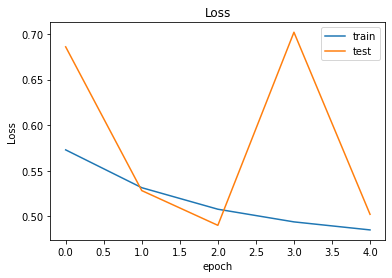

In [92]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

Loss is decreasing with increase in epoch

**Plot graph for Accuracy w.r.t epoch value**

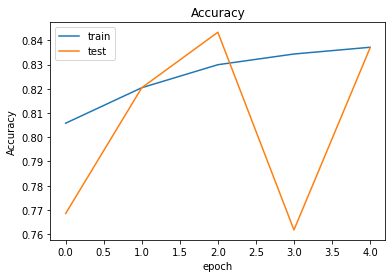

In [93]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [78]:
import numpy as np

new_complaint = ['I LEASED MY CAR ON XX/XX/XXXX AND MADE PAYMENTS UP TO XX/XX/XXXX WHEN MY VEHCILE WAS INVOLVED IN A FLOOD.AT THIS POINT INSURANCE SAID THAT THE CAR WAS TOTALED AND SAID THEY WILL TAKE CARE OF IT WITH THE LEASING COMPANY .AS OF XXXX XXXX XXXX ALL PAYMENTS WHERE MADE TO MY FINANCE COMPANY FROM MY INSURANCE COMPANY AND XXXX FURTHMORE, I RECEIVED AN ALERT XX/XX/XXXX ON MY CREDIT REORT THAT I AM 3 MONTHS BEHIND AND OWE {$1000.00}.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = sequence.pad_sequences(seq, maxlen=maxlen)
pred = model.predict(padded)
labels = ['Checking or savings account',	'Credit card or prepaid card',	'Credit reporting',	'Credit reporting, credit repair services, or other personal consumer reports',	'Debt collection',	'Money transfer, virtual currency, or money service',	'Mortgage',	'Other financial service',	'Student loan or Consumer loan or Vehicle loan or other loans']
print(pred, labels[np.argmax(pred)])

[[3.2216555e-03 4.2442265e-03 2.5229794e-03 3.3572898e-04 2.7385610e-03
  1.1004084e-03 3.5957973e-03 6.0400828e-03 9.7620058e-01]] Student loan or Consumer loan or Vehicle loan or other loans


In [80]:
new_complaint = ["""I have been trying to get my Private Mortgage Insurance Removed from my mortgage since XX/XX/XXXX when my mortgage dropped below 80 % loan to value. Last year my mortgage was sold from XXXX XXXX  ( Under mortgage # XXXX ) to Ditech Mortgage ( account # XXXX ). I reached out to Ditech via a email ( after being told to do so via phone representative ) request to remove my PMI on mortgage on XX/XX/XXXX and received no response at all from them, I even checked my junk box and nothing was there. My mortgage papers that I signed state an Automatic Termination of PMI '' that states once my loan is below 78 % loan to value PMI will automatically terminate ( I have attached this document ). I reached out again today on XX/XX/XXXX to make this request via phone and was told initially to send the request that I already sent it too. I asked to speak with a supervisor and after being put on hold for about 30 minutes, I finally spoke to one. They told me that my loan to value must be under 70 % loan to value and that was their policy. After reading this document to the supervisor, I was told that " they don't have that document on file ''. She ( XXXX XXXX ) sent me a link to send her the form I have. I did so and just told me that I'll be hearing from them in 7-10 business days. Given their past history, I highly doubt that I will hear from them. I did mention to the supervisor and ask her why they weren't staying compliant to the homeowners protection act and she said nothing. From my understand this act requires mortgage companies to drop off PMI once loans are below 78 % LTV and the loan is current. I qualify for both of those items and don't understand why this is such a difficult task."""]
seq = tokenizer.texts_to_sequences(new_complaint)
padded = sequence.pad_sequences(seq, maxlen=maxlen)
pred = model.predict(padded)
labels = ['Checking or savings account',	'Credit card or prepaid card',	'Credit reporting',	'Credit reporting, credit repair services, or other personal consumer reports',	'Debt collection',	'Money transfer, virtual currency, or money service',	'Mortgage',	'Other financial service',	'Student loan or Consumer loan or Vehicle loan or other loans']
print(pred, labels[np.argmax(pred)])

[[9.4165013e-04 6.1971857e-04 2.7717356e-04 6.4157302e-06 2.2415659e-05
  2.3841590e-04 9.9221671e-01 3.8992326e-05 5.6384681e-03]] Mortgage
